# NLP - Drill – Advanced Text Extraction

In [7]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

### Comparing LSA, LDA, and NNMF

Now that you've been introduced to the logic behind these three topic extraction methods, we're going to try them out on the Emma corpus. We'll be looking at interpretability, speed, and consistency across methods. The goal is to identify common themes in Emma on a per-paragraph basis. We won't be using pLSA as sklearn does not support it.

To do this, we will:

1. Parse and process the data into a tf-idf matrix.
2. Fit LSA, LDA, and NNMF models with 5 topics each.
3. Extract the words that best describe each topic.
4. Examine the topic relationships for the words 'marriage', 'love', and 'Emma.'

### Generating the tfidf matrix

In [51]:
# Importing the data

f = open('61435.txt', 'r')
content = f.read()
print(content)

From: newsdesk@jplpost.jpl.nasa.gov (JPL Public Information)
Subject: JPL Info Summary/"Our Solar System at a Glance"

This file and other text and image files from JPL missions are
available from the JPL Info public access computer site,
reachable by Internet via anonymous ftp to pubinfo.jpl.nasa.gov
(128.149.6.2); or by dialup modem to +1 (818) 354-1333, up to
9600 bits per second, parameters N-8-1.
-----------------------------------------------------------------

Our Solar System at a Glance

Information Summary 
PMS 010-A (JPL)
June 1991

JPL 410-34-1  6/91

NASA
National Aeronautics and Space Administration

Jet Propulsion Laboratory
California Institue of Technology
Pasadena, California


For a printed copy of this publication contact the public mail
office at the NASA center in your geographic region.



INTRODUCTION

     From our small world we have gazed upon the cosmic ocean for
untold thousands of years. Ancient astronomers observed points of
light that appeared to move am

In [55]:
# Converting from string to list

content_list = content.split("\n")
content_paras = list(content_list)
content_paras


['From: newsdesk@jplpost.jpl.nasa.gov (JPL Public Information)',
 'Subject: JPL Info Summary/"Our Solar System at a Glance"',
 '',
 'This file and other text and image files from JPL missions are',
 'available from the JPL Info public access computer site,',
 'reachable by Internet via anonymous ftp to pubinfo.jpl.nasa.gov',
 '(128.149.6.2); or by dialup modem to +1 (818) 354-1333, up to',
 '9600 bits per second, parameters N-8-1.',
 '-----------------------------------------------------------------',
 '',
 'Our Solar System at a Glance',
 '',
 'Information Summary ',
 'PMS 010-A (JPL)',
 'June 1991',
 '',
 'JPL 410-34-1  6/91',
 '',
 'NASA',
 'National Aeronautics and Space Administration',
 '',
 'Jet Propulsion Laboratory',
 'California Institue of Technology',
 'Pasadena, California',
 '',
 '',
 'For a printed copy of this publication contact the public mail',
 'office at the NASA center in your geographic region.',
 '',
 '',
 '',
 'INTRODUCTION',
 '',
 '     From our small world we

In [57]:
# Creating the tf-idf matrix.

vectorizer = TfidfVectorizer(stop_words='english')
content_paras_tfidf=vectorizer.fit_transform(content_paras)

# Getting the word list.
terms = vectorizer.get_feature_names()

# Number of topics.
ntopics=5

# In addition to creating the tfidf matrix, there are two convenience functions that will help keep the 
# code tidy when comparing models. The first provides a list of the words that are paired with each topic. 
# The second gives us the best words for each topic so we can compare across methods.

# Linking words to topics
def word_topic(tfidf,solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=chosenlist
    return(topwords)

# Number of words to look at for each topic.
n_top_words = 10

### Fitting the three topic extraction models

In [70]:
# LSA 

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
content_lsa = lsa.fit_transform(content_paras_tfidf)

components_lsa = word_topic(content_paras_tfidf, content_lsa, terms)

topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)

In [71]:
# LDA


from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_topics=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

content_lda = lda.fit_transform(content_paras_tfidf) 

components_lda = word_topic(content_paras_tfidf, content_lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)

C:\Users\femis\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [72]:
# NNMF

from sklearn.decomposition import NMF

nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
content_nmf = nmf.fit_transform(content_paras_tfidf) 

components_nmf = word_topic(content_paras_tfidf, content_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

In [77]:
topwords.head()

,LSA,LDA,NNMF
0,planet 13.6,planet 5.39,surface 2.87
0,earth 11.69,years 4.73,degrees 0.83
0,moon 11.04,kilometers 4.68,temperature 0.45
0,spacecraft 9.17,miles 4.63,celsius 0.43
0,atmosphere 8.83,solar 3.69,planet 0.38


### Inspecting the topics

For each topic, we list the ten most-relevant words according to each method:

In [74]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])
    

Topic 0:
               LSA              LDA              NNMF
0      planet 13.6      planet 5.39      surface 2.87
0      earth 11.69       years 4.73      degrees 0.83
0       moon 11.04  kilometers 4.68  temperature 0.45
0  spacecraft 9.17       miles 4.63      celsius 0.43
0  atmosphere 8.83       solar 3.69       planet 0.38
0       solar 8.08       space 3.31          ice 0.36
0       venus 7.69      surface 3.1   fahrenheit 0.32
0     jupiter 7.68      uranus 3.06        venus 0.32
0      saturn 7.37        moon 3.02   atmosphere 0.31
0       years 7.22  atmosphere 2.88         moon 0.28
Topic 1:
               LSA             LDA            NNMF
1      solar 14.83       earth 5.4      solar 4.49
1    planets 10.32       moon 4.64    planets 2.63
1   asteroids 4.23      solar 4.04        sun 0.75
1       comets 3.7    planets 3.18    jupiter 0.68
1      saturn 3.64     planet 3.08  asteroids 0.57
1         sun 3.44    degrees 2.93     comets 0.57
1     jupiter 3.38  spacecraft 

A number of things are clear. First, some topics are shared, though the order of topics varies- the 'oh' topic is first for LSA and NNMF, but second for LDA. And second, the content of some of the topics varies considerably across methods. This is a clear argument for using multiple methods when exploring topics.

### Sparsity

Now let's examine sparsity by looking at the distributions of loadings for the words 'planet','earth','moon','solar' across the methods:

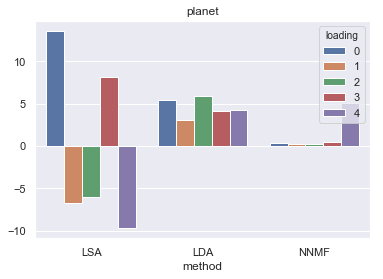

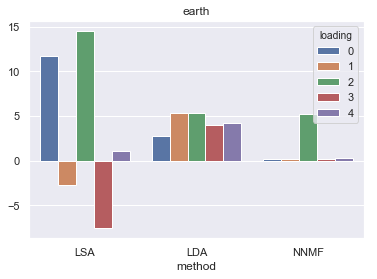

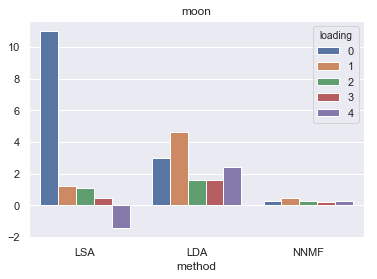

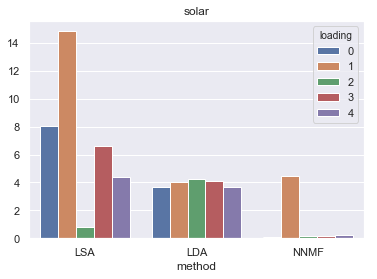

In [76]:
# The words to look at.
targetwords=['planet','earth','moon','solar']

# Storing the loadings.
wordloadings=pd.DataFrame(columns=targetwords)

# For each word, extracting and string the loadings for each method.
for word in targetwords:
    loadings=components_lsa.loc[word].append(
        components_lda.loc[word]).append(
            components_nmf.loc[word])
    wordloadings[word]=loadings

# Labeling the data by method and providing an ordering variable for graphing purposes. 
wordloadings['method']=np.repeat(['LSA','LDA','NNMF'], 5, axis=0)
wordloadings['loading']=[0,1,2,3,4]*3

sns.set(style="darkgrid")

for word in targetwords:
    sns.barplot(x="method", y=word, hue="loading", data=wordloadings)
    plt.title(word)
    plt.ylabel("")
    plt.show()

LSA is the method most likely to have high loadings on more than one topic for the same word. LDA tends to have one high loading and some lower loadings. Loadings for NNMF are lower all around, and the most sparse, with some of the topics having loadings of zero on each word.